# Reconhecimento de Dígitos com CNNs 🔢

Um treinamento de uma rede CNN para reconhecer digitos manuscritos usando a base de dados MNIST, apresentando taxas de acerto totais (precision, recall e accuracy) e por classe (accuracy).

Feito por: 
- Gabriel Kristian Queiroz de Souza Jales, 
- Josué Fidelis de Oliveira Neto,
- Leão Liu Masur,
- Luana Porciuncula Barreto.

In [ ]:
!pip install -qU ipdb

In [ ]:
!pip install mlxtend --upgrade --no-deps

In [ ]:
import torch
import numpy as np
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import copy
import ipdb
import pickle

use_gpu = torch.cuda.is_available()

In [ ]:
!nvidia-smi

Tue Nov  2 19:20:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |    559MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Carregando e Divisão de Dados**

Como nesta parte do projeto irá ser utilizado o pytorch, os dados serão carregados diretos pela bilbioteca de datasets do próprio pytorch para facilitar a integração. Também foi verificado que eles se tratam dos mesmo dados que foram utilizados na primeira parte do projeto.

In [ ]:
# Converte os dados para um FloatTensor 
transform = transforms.ToTensor()

# Escolhe os dados de treino e teste
train_data = datasets.MNIST(root="datasets", train=True,
                              download=True, transform=transform)
test_data = datasets.MNIST(root="datasets", train=False,
                             download=True, transform=transform)

train_data, val_data = torch.utils.data.random_split(train_data, [50000, 10000])

In [ ]:
# Define o carregamento dos dados utilizado os dados escolhidos
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data)
test_loader = DataLoader(test_data)

**Visualização dos dados**

Label: 7


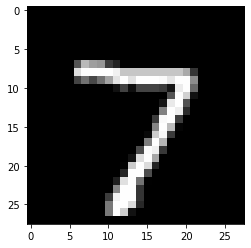

In [ ]:
visualization = copy.deepcopy(test_data)
visualization.transform = None

index = 0
image, label = visualization[index]
plt.imshow(image, cmap='gray')
print('Label:', label)

**Definição do Modelo**

Para a definção da topologia, usaremos 3 camadas de convolução, com canais de saída 16, 32 e 64 respectivamente. Cada uma com a função de ativação ReLU, tamanho do kernel 3x3, padding de 1 e um max pooling 2x2.

Na ultima convolução teremos 64 canais com tamanho 3x3, onde eles serão *flatten* para um vetor 64x3x3 e passado numa camada de dropout com probabilidade de 25%.

A partir desse ponto teremos duas redes diferentes:

- **1** - Passar direto o vetor resultante para a camada de saída com 10 neuronios
- **2** - Ter uma camada com 500 neuronios entre a convolução e a saída.

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, net_type=1):
        super(CNN, self).__init__()

        self.net_type = net_type

        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1),
                                nn.ReLU(True),
                                nn.MaxPool2d(2, 2))
        
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1),
                                nn.ReLU(True),
                                nn.MaxPool2d(2, 2))
        
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1),
                                nn.ReLU(True),
                                nn.MaxPool2d(2, 2))
        
        if self.net_type == 1:
            self.fc1 = nn.Linear(64*3*3, 10)
        else:
            self.fc1 = nn.Sequential(nn.Linear(64*3*3, 500),
                                nn.ReLU(True))
        
        self.fc2 = nn.Linear(500, 10)

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # (batch_size, channels, Height, Width)
        # x.shape == (32, 3, 28, 28)
        x = self.conv1(x)
        # x.shape == (32, 16, 14, 14)
        x = self.conv2(x)
        # x.shape == (32, 32, 7, 7)
        x = self.conv3(x)
        # x.shape == (32, 64, 3, 3)
        # transforma a imagem num vetor bidimensional (flatten)
        # 64 canais x 3H x 3W
        x = x.view(-1, 64*3*3)

        x = self.dropout(x)

        if self.net_type == 1:
            return self.fc1(x)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

Usaremos a Cross Entropy Loss como a função custo

In [ ]:
criterion = nn.CrossEntropyLoss()

## Treinamento e calibragem de hiperparâmetros

Para otimizar os resultados obtidos, selecionamos 3 parâmetros para variar entre os seguintes valores:
- **Learning rate**: 0.001, 0.003, 0.0001 e 0.0003
- **Optimizador**: SGD e Adam
- **Tipo da rede**: 1 e 2 (como definidos acima)

E será rodado um total de 4x2x2 combinações diferentes.

In [ ]:
learning_rates = [0.001, 0.003, 0.0001, 0.0003]
optimizers = [optim.SGD, optim.Adam]
net_type = [1, 2]

In [ ]:
best_hyperparams = ()
best_loss = np.inf

In [ ]:
def train(learning_rate, optimizer, net_type):
    print(f"learning rate: {learning_rate} \t optimizer: {optimizer} \t net type: {net_type}")
    model = CNN(net_type=net_type)

    if use_gpu:
        torch.cuda.init()
        model.cuda()
        cudnn.benchmark = True
    
    opt = optimizer(model.parameters(), lr=learning_rate)

    n_epocas = 30
    train_losses = []
    val_losses = []


    for epoca in range(n_epocas):
        loss_treino = 0

        model.train()
        for x, y in train_loader:
            # ipdb.set_trace()
            if use_gpu:
                x, y = x.cuda(), y.cuda()

            opt.zero_grad()

            pred = model(x)
            # ipdb.set_trace()
            loss = criterion(pred, y)

            loss.backward()

            opt.step()
            loss_treino += loss

        loss_treino = loss_treino/len(train_loader.dataset)
        train_losses.append(loss_treino)

        loss_val = 0
        model.eval()
        for x, y in val_loader:
            if use_gpu:
                x, y = x.cuda(), y.cuda()
            
            with torch.no_grad():
                pred = model(x)

                loss = criterion(pred, y)

                loss_val += loss
        loss_val = loss_val/len(val_loader.dataset)
        val_losses.append(loss_val)


        # print(f"Epoca {epoca+1}/{n_epocas} \t Loss de Treinamento: {loss_treino} \t Loss de Validacao: {loss_val}")

    losses_slice = int(0.9 * n_epocas)
    # train_losses = train_losses[losses_slice:]
    val_losses = val_losses[losses_slice:]

    val_losses = torch.mean(torch.stack(val_losses)).item()

    # val_losses = val_losses[-1]

    global best_loss
    global best_hyperparams

    if val_losses < best_loss:
        best_loss = val_losses
        best_hyperparams = (learning_rate, optimizer, net_type)

In [ ]:
for lr in learning_rates:
    for opt in optimizers:
        for nt in net_type:
            train(lr, opt, nt)

In [ ]:
best_hyperparams, best_loss

((0.0001, torch.optim.adam.Adam, 2), 0.024892589077353477)

#### Hiperparâmetros ótimos

Ao final da etapa de calibragem, encontramos como a melhor configuração com base na loss:
- **Learning rate**: 0.0001
- **Optimizador**: Adam
- **Tipo da rede**: 2

### Treino

Com os hiperparâmetros ótimos adquiridos na parte de calibração, iniciamos a etapa de treinamento da rede, monitorando a loss de treinamento e validação a cada época.

In [ ]:
model = CNN(net_type=2)

if use_gpu:
    torch.cuda.init()
    model.cuda()
    cudnn.benchmark = True

opt = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epocas = 50
train_losses = []
val_losses = []


for epoca in range(n_epocas):
    loss_treino = 0

    model.train()
    for x, y in train_loader:
        if use_gpu:
            x, y = x.cuda(), y.cuda()

        opt.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)

        loss.backward()

        opt.step()
        loss_treino += loss

    loss_treino = loss_treino/len(train_loader.dataset)
    train_losses.append(loss_treino)

    loss_val = 0
    model.eval()
    for x, y in val_loader:
        if use_gpu:
            x, y = x.cuda(), y.cuda()
        
        with torch.no_grad():
            pred = model(x)

            loss = criterion(pred, y)

            loss_val += loss
    loss_val = loss_val/len(val_loader.dataset)
    val_losses.append(loss_val)

    print(f"Epoca {epoca+1}/{n_epocas} \t Loss de Treinamento: {loss_treino} \t Loss de Validacao: {loss_val}")


Epoca 1/50 	 Loss de Treinamento: 0.0163589958101511 	 Loss de Validacao: 0.14855138957500458
Epoca 2/50 	 Loss de Treinamento: 0.004654645919799805 	 Loss de Validacao: 0.0957166850566864
Epoca 3/50 	 Loss de Treinamento: 0.0034751826897263527 	 Loss de Validacao: 0.07700323313474655
Epoca 4/50 	 Loss de Treinamento: 0.0028441224712878466 	 Loss de Validacao: 0.06841122359037399
Epoca 5/50 	 Loss de Treinamento: 0.0024278927594423294 	 Loss de Validacao: 0.0556107722222805
Epoca 6/50 	 Loss de Treinamento: 0.002179165370762348 	 Loss de Validacao: 0.05337559059262276
Epoca 7/50 	 Loss de Treinamento: 0.001928785932250321 	 Loss de Validacao: 0.04746825248003006
Epoca 8/50 	 Loss de Treinamento: 0.0017383641097694635 	 Loss de Validacao: 0.047276370227336884
Epoca 9/50 	 Loss de Treinamento: 0.0015676997136324644 	 Loss de Validacao: 0.0401548370718956
Epoca 10/50 	 Loss de Treinamento: 0.0014370910357683897 	 Loss de Validacao: 0.041445292532444
Epoca 11/50 	 Loss de Treinamento: 0.00

## Resultados

Com os dados obtidos do treinamento e da validação, obtemos a loss por época para análise do aprendizado. E com o modelo treinado, vamos classificar o conjunto de teste e avaliar os resultados com o classification report e a matriz de confusão

In [ ]:
model.eval()
loss_test = 0
y_test = []
y_pred = []
wrongs = []
for x, y in test_loader:
    if use_gpu:
        x, y = x.cuda(), y.cuda()

    pred = model(x)

    loss = criterion(pred, y)
  
    loss_test += loss

    _, pred = torch.max(pred, 1)

    if y.item() !== pred.item():
        wrongs.append({
            "x": x,
            "y": y,
            "pred": pred
        })

    y_test.append(y.item())
    y_pred.append(pred.item())

with open('wrongs', 'wb') as arquivo:
    pickle.dump(wrongs, arquivo)

print(classification_report(y_test, y_pred))
loss_test = loss_test/len(val_loader.dataset)
print(f"Loss de teste: {loss_test}")

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       1.00      0.99      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Loss de teste: 0.024115225300192833


##### Taxas de acerto totais
- *Accuracy* : 0.99
- *Precision* : 0.99 
- *Recall* : 0.99

##### Comparação dos taxas de acerto

Comparando o classification report do CNN com a do MLP, podemos perceber uma grande melhora na performance. 

Encontramos com o CNN taxas totais de *accuracy*, *precision* e *recall* de **0.99**, enquanto as taxas totais de *accuracy*, *precision* e *recall* do MLP eram de **0.96**.
Também no classification report podemos perceber que as taxas de acerto por classe do CNN são muito mais uniformes, variando entre **0.99 e 1.00**, enquanto as do MLP variam entre **0.93 e 0.98**. 

![MLP Classification Report](MLP_Classification_Report.png)

#### Matriz de confusão

Matriz de confusão dos resultados da CNN, abaixo: resultado esperado x resposta da CNN.

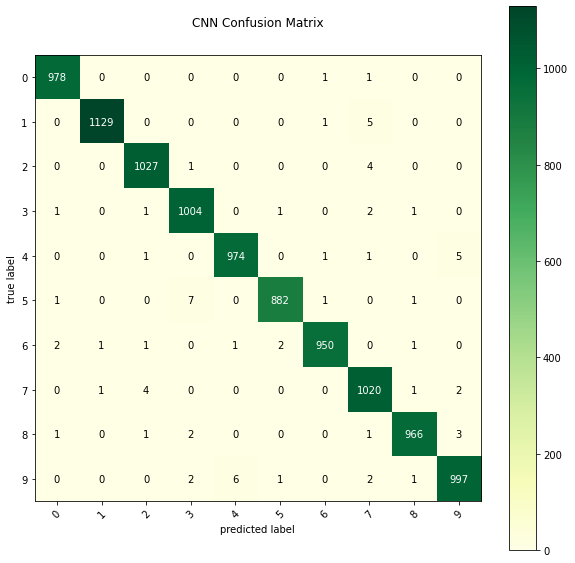

In [ ]:
cm = confusion_matrix(y_test, y_pred)
classes = list(map(lambda x: str(x), range(10)))

fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True, class_names=classes, figsize=(10, 10), cmap='YlGn')
ax.set_title("CNN Confusion Matrix")
plt.show()

Como pode ser observado, o modelo obteve uma performance boa, com os únicos pontos a se destacar sendo 6 previsões erradas do 9 para o 4, e 7 previsões erradas do 3 para o 5.

Podemos plotar esses caracteres preditos errados para ver se são erros razoáveis de ocorrer numa rede, podendo até ter confusão para um ser humano.

In [ ]:
with open('wrongs', 'rb') as arquivo:
    wrongs = pickle.load(arquivo)

In [ ]:
def plot_wrong(wrong):
    pred = wrong["pred"].numpy()
    x = wrong["x"].numpy()
    y = wrong["y"].numpy()

    plt.imshow(x[0][0], cmap='gray')
    print(f'Label: {y[0]} \t Pred: {pred[0]}')

Label: 3 	 Pred: 5


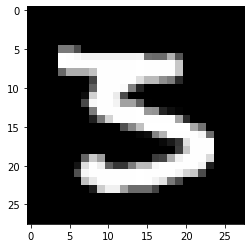

In [ ]:
plot_wrong(wrongs[1])

Label: 8 	 Pred: 9


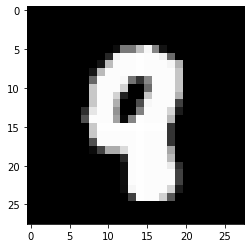

In [ ]:
plot_wrong(wrongs[4])

##### Comparação das matrizes de confusão

Comparando as matrizes do CNN com a do MLP, também podemos perceber uma grande melhora na performance. 

Na matriz de  confusão do CNN, os casos de *predicted labels* incorretos são escassos, já na matriz de confusão do MLP estes casos se tornaram mais frequentes em relação a da CNN.

![MLP Confusion Matrix](MLP_Confusion_Matrix.png)

#### Loss por época

Gráfico da loss por época nos conjutos de validação e de treino.

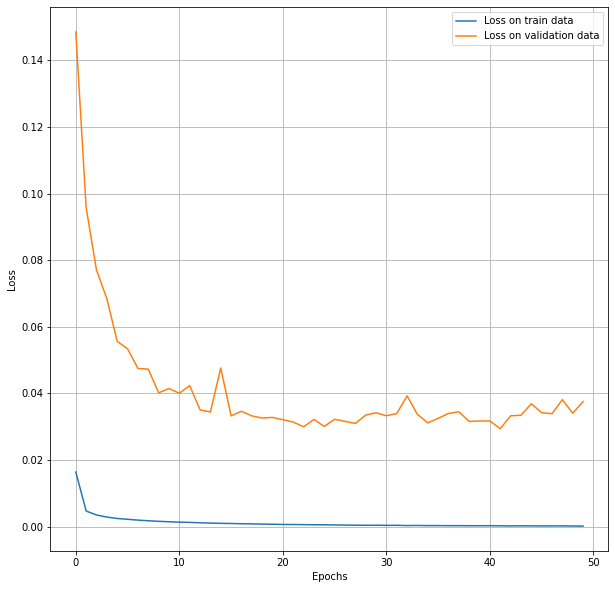

In [ ]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot()

t = list(range(50))
#x = t
#y = s1/s2
line1, = ax1.plot(t, train_losses, label='Loss on train data')

line2, = ax1.plot(t, val_losses, label='Loss on validation data')

# ax1.set_xlim(0, 30)
# ax1.set_ylim(0.9, 1)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax1.legend()
plt.show()

##### Análise de generalização
Interpretando o gráfico de loss por época, podemos assumir uma baixa variância com base na distância entre as curvas de treino e validação. E podemos assumir um baixo *bias* com base na distância da curva de treino para 0.00. Com isso, podemos assumir que não está ocorrendo *underfitting*, nem *overfitting*.

Logo, podemos perceber que nosso modelo tem uma boa generalização. Como também pode ser observado pela performace no conjunto de testes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9bcf13e-bf05-46ce-ab96-502b8a23123f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>